In [1]:
using Distributions,StatsPlots,Turing,DataFrames,CSV,Optim,NamedArrays

https://hokkaido-marathon.com/data/distribution/

北海道マラソン2022の記録
|タイム|男子	|女子	|合計
|------|-----|-----|-----
|2:10:01~2:20:00	| 30	 | 0	|30
|2:20:01~2:30:00	| 35	 | 1	|36
|2:30:01~2:40:00	| 73	 | 3	|76
|2:40:01~2:50:00	| 151	| 3	| 154
|2:50:01~3:00:00	| 332	| 15	| 347
|3:00:01~3:10:00	| 284	| 25	| 309
|3:10:01~3:20:00	| 455	| 53	| 508
|3:20:01~3:30:00	| 583	| 71	| 654
|3:30:01~3:40:00	| 548	| 81	| 629
|3:40:01~3:50:00	| 685	| 94	| 779
|3:50:01~4:00:00	| 932	| 142	| 1,074
|4:00:01~4:10:00	| 643	| 140	| 783
|4:10:01~4:20:00	| 833	| 163	| 996
|4:20:01~4:30:00	| 837	| 181	| 1,018
|4:30:01~4:40:00	| 759	| 196	| 955
|4:40:01~4:50:00	| 791	| 213	| 1,004
|4:50:01~5:00:00	| 860	| 250	| 1,110
|5:00:01~5:10:00	| 718	| 208	| 926
|5:10:01~5:20:00	| 679	| 191	| 870
|5:20:01~5:30:00	| 698	| 208	| 906
|5:30:01~5:40:00	| 663	| 218	| 881
|5:40:01~5:50:00	| 729	| 206	| 935
|5:50:01~	| 1,196	| 339	| 1,535
|総計	| 13,514	| 3,001 | 	16,515

In [2]:
df = CSV.read("hokkaido-marason_2022.csv",DataFrame)

Row,TIME_LEVEL,GOAL_MINUTE,GOAL_MALE,GOAL_FEMALE,GOAL
,String15,Int64,Int64,Int64,Int64
1,2:10:01~2:20:00,20,30,0,30
2,2:20:01~2:30:00,30,35,1,36
3,2:30:01~2:40:00,40,73,3,76
4,2:40:01~2:50:00,50,151,3,154
5,2:50:01~3:00:00,60,332,15,347
6,3:00:01~3:10:00,70,284,25,309
7,3:10:01~3:20:00,80,455,53,508
8,3:20:01~3:30:00,90,583,71,654
9,3:30:01~3:40:00,100,548,81,629


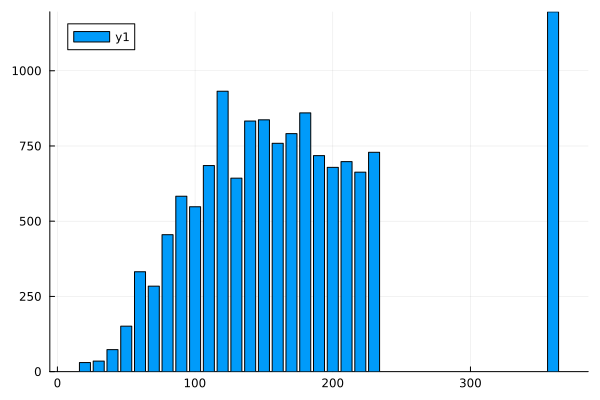

In [3]:
#@df df plot(:GOAL_MINUTE, :GOAL_FEMALE, st=:stephist, bins=20)
@df df bar(:GOAL_MINUTE, :GOAL_MALE)

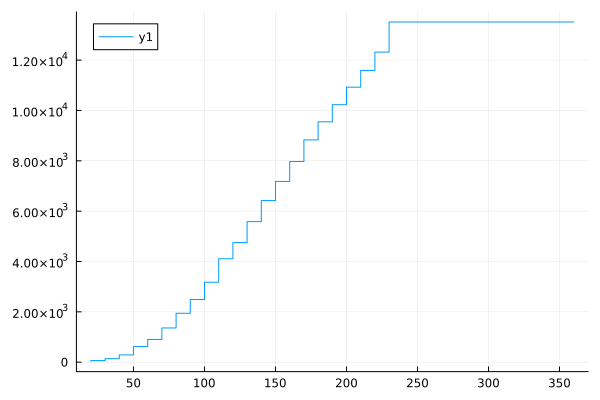

In [4]:
xs = df.GOAL_MINUTE |> Vector
ys_man = df.GOAL_MALE |> t-> accumulate(+,t)
ys_women = df.GOAL_FEMALE |> t-> accumulate(+,t)
plot(xs, ys_man, st=:steppre)

In [5]:
ys_man_accum = ys_man ./ ys_man[end]
ys_women_accum = ys_women ./ ys_women[end]

23-element Vector{Float64}:
 0.0
 0.0003332222592469177
 0.0013328890369876708
 0.0023325558147284237
 0.007330889703432189
 0.015661446184605132
 0.03332222592469177
 0.056981006331222925
 0.08397200933022327
 0.11529490169943352
 0.16261246251249584
 0.2092635788070643
 0.2635788070643119
 0.323892035988004
 0.38920359880039984
 0.46017994001999335
 0.5434855048317228
 0.6127957347550816
 0.676441186271243
 0.7457514161946018
 0.8183938687104299
 0.8870376541152949
 1.0

In [6]:
@model function gamma_param_find(xs,qs)
    a ~ InverseGamma(2,3)
    b ~ InverseGamma(2,3)
    s ~ Exponential(1)
    dist=Gamma(a,b)
    for i = 1:length(xs)
        if xs[i] != 0
            xs[i] ~ Normal( quantile(dist,qs[i]) , sqrt(s) )    
        end
    end
end

gamma_param_find (generic function with 2 methods)

In [7]:
model = gamma_param_find(xs[1:end-1],ys_man_accum[1:end-1])
wmodel = gamma_param_find(xs[1:end-1],ys_women_accum[1:end-1])

DynamicPPL.Model{typeof(gamma_param_find), (:xs, :qs), (), (), Tuple{Vector{Int64}, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(gamma_param_find, (xs = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110  …  140, 150, 160, 170, 180, 190, 200, 210, 220, 230], qs = [0.0, 0.0003332222592469177, 0.0013328890369876708, 0.0023325558147284237, 0.007330889703432189, 0.015661446184605132, 0.03332222592469177, 0.056981006331222925, 0.08397200933022327, 0.11529490169943352  …  0.2635788070643119, 0.323892035988004, 0.38920359880039984, 0.46017994001999335, 0.5434855048317228, 0.6127957347550816, 0.676441186271243, 0.7457514161946018, 0.8183938687104299, 0.8870376541152949]), NamedTuple(), DynamicPPL.DefaultContext())

In [8]:
opt_model = optimize(model,MAP(),NelderMead())
opt_wmodel = optimize(wmodel,MAP(),NelderMead())

ModeResult with maximized lp of -116.53
[8.839470325059914, 19.762402904054536, 20.304251701543937]

In [9]:
opt_model.values[:a]

5.808602561182263

In [10]:
dist=Gamma(opt_model.values[:a],opt_model.values[:b])
wdist=Gamma(opt_wmodel.values[:a],opt_wmodel.values[:b])

Gamma{Float64}(α=8.839470325059914, θ=19.762402904054536)

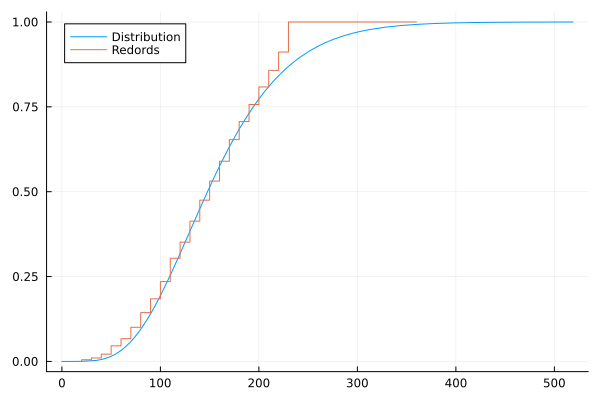

In [11]:
plot(dist,func=cdf,label="Distribution")
plot!(xs, ys_man_accum, st=:steppre,label="Redords")

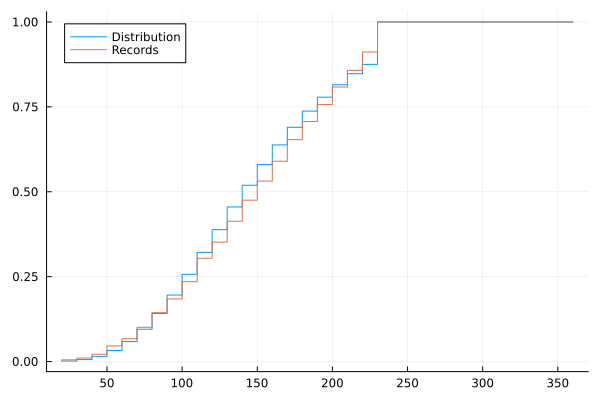

In [12]:
ss=rand(dist,200000) #ys_man[end])
ds=zeros(length(ys_man))
for e in ss
    for i = 1:length(xs)
        if e < xs[i]
            ds[i] += 1
        end
    end
end
ds = ds ./ ds[end]
plot(xs,ds,st=:steppre, label="Distribution")
plot!(xs, ys_man_accum, st=:steppre, label="Records")

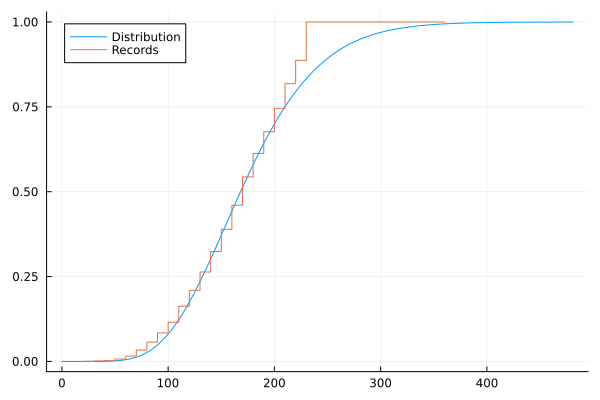

In [13]:
plot(wdist,func=cdf,label="Distribution")
plot!(xs, ys_women_accum, st=:steppre,label="Records")

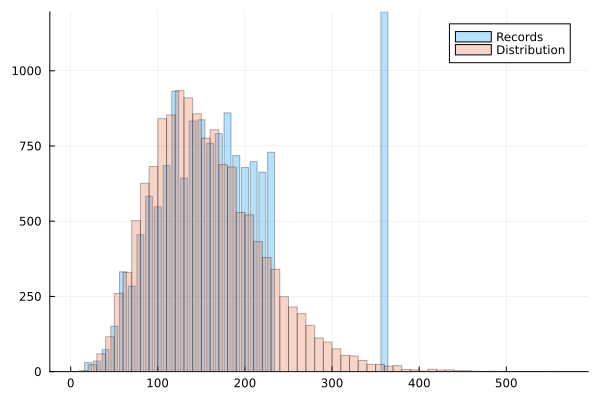

In [14]:
@df df bar(:GOAL_MINUTE,:GOAL_MALE,alpha=0.3,label="Records")
histogram!(rand(dist,ys_man[end]),alpha=0.3,label="Distribution")

In [15]:
@model function mixed_gamma_param_find(xs,qs ; K=2)
    
    w  ~ Dirichlet(ones(K)/K)
    as ~ arraydist([truncated(Cauchy(0,2),0,Inf) for i = 1:K])
    bs ~ arraydist([truncated(Cauchy(0,2),0,Inf) for i = 1:K])
    s  ~ Exponential(1)
    
    dists = MixtureModel([Gamma(a,b) for (a,b) in zip(as,bs)],w)
    
    for i = 1:length(xs)
        if xs[i] != 0
            xs[i] ~ Normal( quantile(dists,qs[i]) , sqrt(s) )    
        end
    end
end

mixed_gamma_param_find (generic function with 2 methods)

In [16]:
model = mixed_gamma_param_find(xs[1:end-1],ys_man_accum[1:end-1])
wmodel = mixed_gamma_param_find(xs[1:end-1],ys_women_accum[1:end-1])

DynamicPPL.Model{typeof(mixed_gamma_param_find), (:xs, :qs), (:K,), (), Tuple{Vector{Int64}, Vector{Float64}}, Tuple{Int64}, DynamicPPL.DefaultContext}(mixed_gamma_param_find, (xs = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110  …  140, 150, 160, 170, 180, 190, 200, 210, 220, 230], qs = [0.0, 0.0003332222592469177, 0.0013328890369876708, 0.0023325558147284237, 0.007330889703432189, 0.015661446184605132, 0.03332222592469177, 0.056981006331222925, 0.08397200933022327, 0.11529490169943352  …  0.2635788070643119, 0.323892035988004, 0.38920359880039984, 0.46017994001999335, 0.5434855048317228, 0.6127957347550816, 0.676441186271243, 0.7457514161946018, 0.8183938687104299, 0.8870376541152949]), (K = 2,), DynamicPPL.DefaultContext())

In [17]:
opt_model = optimize(model,MLE(),NelderMead())
opt_wmodel = optimize(wmodel,MLE(),NelderMead())

┌ Warning: Optimization did not converge! You may need to correct your model or adjust the Optim parameters.
└ @ TuringOptimExt C:\Users\kimse\.julia\packages\Turing\UCuzt\ext\TuringOptimExt.jl:241


LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [1:2]

In [18]:
opt_model.values

3-element Named Vector{Float64}
A  │ 
───┼────────
a  │  5.8086
b  │ 26.9756
s  │ 18.0098

In [19]:
ws = opt_model.values.array[1:2]
as = opt_model.values.array[3:4]
bs = opt_model.values.array[5:6]
dists = MixtureModel([Gamma(a,b) for (a,b) in zip(as,bs)],ws)

LoadError: BoundsError: attempt to access 3-element Vector{Float64} at index [3:4]

In [20]:
@df df bar(:GOAL_MINUTE,:GOAL_MALE,alpha=0.3,label="Records")
histogram!(rand(dists,ys_man[end]),alpha=0.3,label="Distribution")

LoadError: UndefVarError: `dists` not defined

In [21]:
plot(dists,func=pdf,label="")

LoadError: UndefVarError: `dists` not defined

In [22]:
ss=rand(dists,200000) #ys_man[end])
ds=zeros(length(ys_man))
for e in ss
    for i = 1:length(xs)
        if e < xs[i]
            ds[i] += 1
        end
    end
end
ds = ds ./ ds[end];
plot(xs,ds, st=:steppre)
plot!(xs, ys_man_accum, st=:steppre)

LoadError: UndefVarError: `dists` not defined

In [23]:
ss=rand(dists,5000) 
histogram(ss)

LoadError: UndefVarError: `dists` not defined